# Dataset Registry & Visualization using Amazong Glue Catalog & Amazon Athena

## 1. Import & Transform raw dataset

In [2]:
!aws s3 cp s3://$bucket/data/raw/BankChurners.csv ./Data Acquisition & Registry/data/BankChurners.csv


/bin/bash: line 1: Registry/data/BankChurners.csv: No such file or directory


In [3]:
import pandas as pd


local_data_path = './data/BankChurners.csv'
data = pd.read_csv(local_data_path)

data.shape


(10127, 23)

In [4]:
data.head()


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0,1
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0,1
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0,1
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0,1
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0,1


### Transofrm the data

In [5]:
data_transformed = data.rename(columns={
        'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1':'churn_mon1',
        'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2':'churn_mon2'
        })

data_transformed.dropna(inplace = True)
data_transformed.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

### Write data to local CSV file

In [6]:
import os


local_directory = './data/DatasetRegistration'
outname1 = 'BankChurners_month1_transformed.csv'
outname2 = 'BankChurners_month2_transformed.csv'

try:
    data_transformed.drop(columns = ['churn_mon2']).to_csv(os.path.join(local_directory, outname1), index=False)
    data_transformed.drop(columns = ['churn_mon1']).to_csv(os.path.join(local_directory, outname2), index=False)
except OSError:
    os.mkdir(local_directory)
    data_transformed.drop(columns = ['churn_mon2']).to_csv(os.path.join(local_directory, outname1), index=False)
    data_transformed.drop(columns = ['churn_mon1']).to_csv(os.path.join(local_directory, outname2), index=False)
    

## 2. Register S3 Dataset as a table to enable querying

In [7]:
import os
import sagemaker
import logging
import boto3
import time
import json
import botocore
from botocore.exceptions import ClientError


# ========================== low-level service client of the boto3 session ==========================
config = botocore.config.Config(user_agent_extra='bedissj-1699438736259')


sm = boto3.client(service_name='sagemaker', 
                  config=config)

sm_runtime = boto3.client('sagemaker-runtime',
                          config=config)

sess = sagemaker.Session(sagemaker_client=sm,
                         sagemaker_runtime_client=sm_runtime)

bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = sess.boto_region_name


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


### Copy file to S3 Bucket

In [8]:
!aws s3 cp ./data/DatasetRegistration/BankChurners_month1_transformed.csv s3://$bucket/data/transformed_querying/month1/BankChurners_mon1.csv


upload: data/DatasetRegistration/BankChurners_month1_transformed.csv to s3://sagemaker-eu-west-3-668303144976/data/transformed_querying/month1/BankChurners_mon1.csv


In [9]:
!aws s3 cp ./data/DatasetRegistration/BankChurners_month2_transformed.csv s3://$bucket/data/transformed_querying/month2/BankChurners_mon2.csv


upload: data/DatasetRegistration/BankChurners_month2_transformed.csv to s3://sagemaker-eu-west-3-668303144976/data/transformed_querying/month2/BankChurners_mon2.csv


In [13]:
from IPython.display import display, HTML

display(HTML('<b>Review <a target="top" href="https://s3.console.aws.amazon.com/s3/buckets/{}?region={}&prefix=data/transformed_querying/&showversions=false">Amazon S3 buckets</a></b>'.format(bucket, region)))

### Import AWS Data Wrangler & Create AWS Glue Data Catalog

In [14]:
!pip install --disable-pip-version-check -q awswrangler

Create database if it does not already exist.

In [15]:
import awswrangler as wr


database_name = 'bank_churn_prediction'
wr.catalog.create_database(
        name=database_name,
        description='Database for banks customers churn prediction over two months. Each month is represented by a table.',
        exist_ok=True
)


Review list of available databases.

In [16]:
wr.catalog.databases()


,Database,Description
0,bank_churn_prediction,Database for banks customers churn prediction ...
1,default,
2,sagemaker_featurestore,


Review list of available tables.

In [18]:
wr.catalog.tables(database=database_name)


,Database,Table,Description,TableType,Columns,Partitions
0,bank_churn_prediction,bank_churn_month1,,EXTERNAL_TABLE,"clientnum, attrition_flag, customer_age, gende...",
1,bank_churn_prediction,bank_churn_month2,,EXTERNAL_TABLE,"clientnum, attrition_flag, customer_age, gende...",


Create CSV tables and assign the to the destination database.

Map columns types to match AWS Glue Catalog.

In [19]:
# Create dataframe and retrieve columns types

data_mon1 = data_transformed.drop(columns = ['churn_mon2'])
data_types = pd.DataFrame(data_mon1.dtypes.to_dict(), 
                              index = [0]).replace({'int64': 'int',
                                                    'object':'string',
                                                    'float64': 'float'}).T.to_dict()[0]


Create CSV tables for month1 and month2 churn prediction.

In [20]:
# Create CSV table for churn month1

wr.catalog.create_csv_table(
        database=database_name,
        table='bank-churn-month1',
        path='s3://{}/data/transformed_querying/month1/'.format(bucket),
        columns_types=data_types,
        skip_header_line_count=1
)


In [21]:
# Create CSV table for churn month 2

data_mon2 = data_transformed.drop(columns = ['churn_mon1'])
wr.catalog.create_csv_table(
        database=database_name,
        table='bank-churn-month2',
        path='s3://{}/data/transformed_querying/month2/'.format(bucket),
        columns_types=data_types,
        skip_header_line_count=1
)


Review AWS Glue Catalog databases.

In [22]:
from IPython.display import display, HTML

display(HTML('<b>Review <a target="top" href="https://eu-west-3.console.aws.amazon.com/glue/home?region={}#/v2/data-catalog/databases">AWS Glue Catalog databases</a></b>'.format(region)))

## Visualize the data
### Create Athena Bucket for querying

In [23]:
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'


database_name = 'bank_churn_prediction'
athena_table_name = 'bank_churn_month1'

In [24]:
wr.athena.create_athena_bucket()

's3://aws-athena-query-results-668303144976-eu-west-3/'

### Retrieve customers churn table for month1

In [25]:
statement_table = '''
SELECT * 
FROM {}
ORDER BY clientnum
'''.format(athena_table_name)


print(statement_table)


SELECT * 
FROM bank_churn_month1
ORDER BY clientnum



In [26]:
df_churn = wr.athena.read_sql_query(
        sql=statement_table,
        database=database_name
)


df_churn

,clientnum,attrition_flag,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,...,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio,churn_mon1
0,708082083,Existing Customer,45,F,3,High School,Married,Less than $40K,Blue,36,...,3,3544.000000,1661,1883.000000,0.831,15149,111,0.734,0.469,0
1,708083283,Attrited Customer,58,M,0,Unknown,Single,$40K - $60K,Blue,45,...,3,3421.000000,2517,904.000000,0.992,992,21,0.400,0.736,1
2,708084558,Attrited Customer,46,M,3,Doctorate,Divorced,$80K - $120K,Blue,38,...,3,8258.000000,1771,6487.000000,0.000,1447,23,0.000,0.214,1
3,708085458,Existing Customer,34,F,2,Uneducated,Single,Less than $40K,Blue,24,...,2,1438.300049,0,1438.300049,0.827,3940,82,0.952,0.000,0
4,708086958,Existing Customer,49,F,2,Uneducated,Married,Unknown,Blue,41,...,2,3128.000000,749,2379.000000,0.598,4369,59,0.735,0.239,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,828288333,Existing Customer,50,M,0,Uneducated,Married,$60K - $80K,Blue,46,...,3,3640.000000,659,2981.000000,0.938,3756,70,0.842,0.181,0
10123,828291858,Attrited Customer,38,M,3,College,Single,$60K - $80K,Blue,34,...,4,12050.000000,1821,10229.000000,0.630,2381,40,0.481,0.151,1
10124,828294933,Attrited Customer,49,F,3,High School,Married,Less than $40K,Blue,45,...,3,2951.000000,2437,514.000000,0.765,2519,36,0.565,0.826,1
10125,828298908,Existing Customer,54,M,4,Graduate,Married,$120K +,Blue,50,...,0,2872.000000,2035,837.000000,0.613,1770,47,0.741,0.709,0


### Explore  correlations

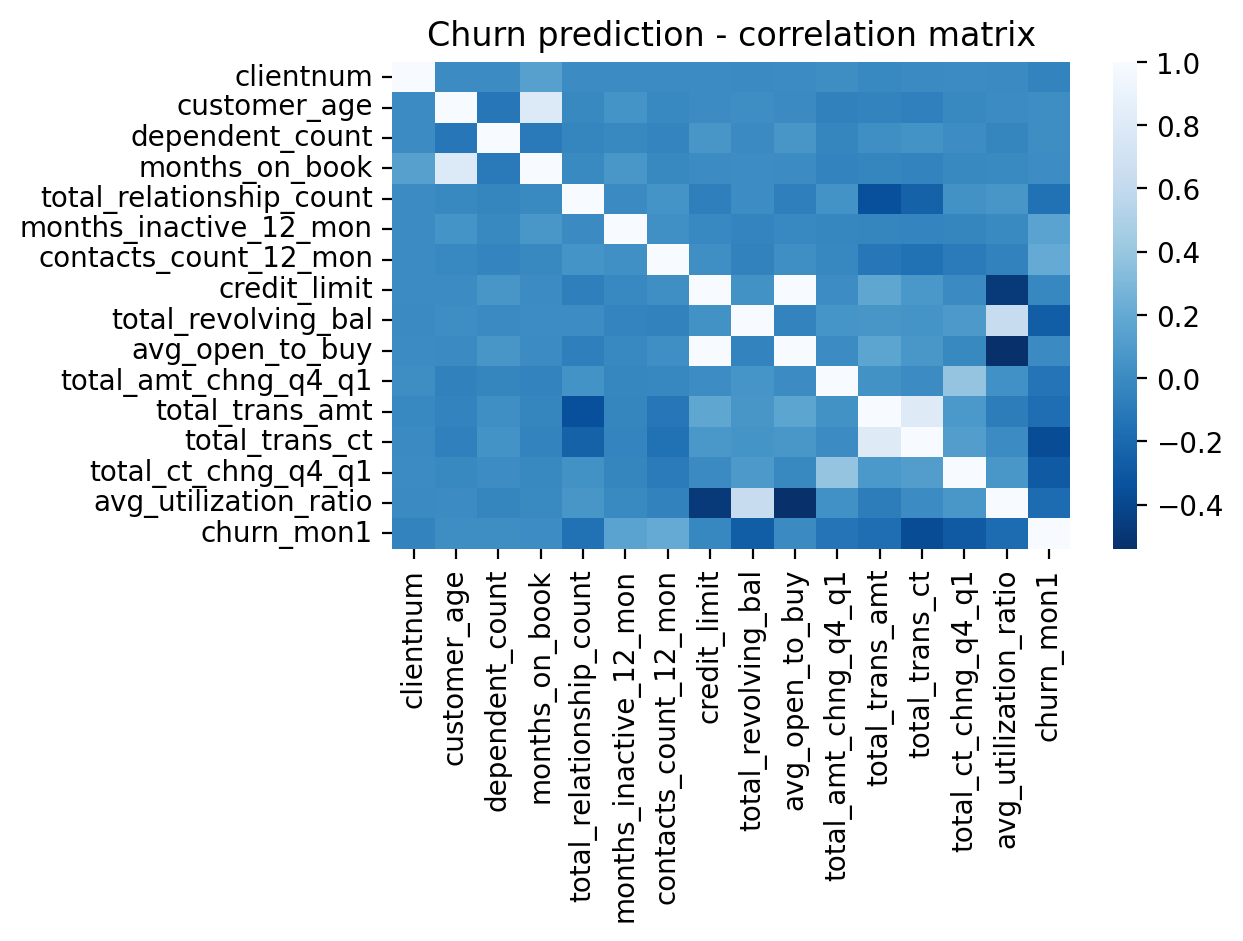

In [27]:
sns.heatmap(df_churn.corr(), cmap = 'Blues_r')
plt.title('Churn prediction - correlation matrix')
plt.tight_layout();


### Explore continuous features

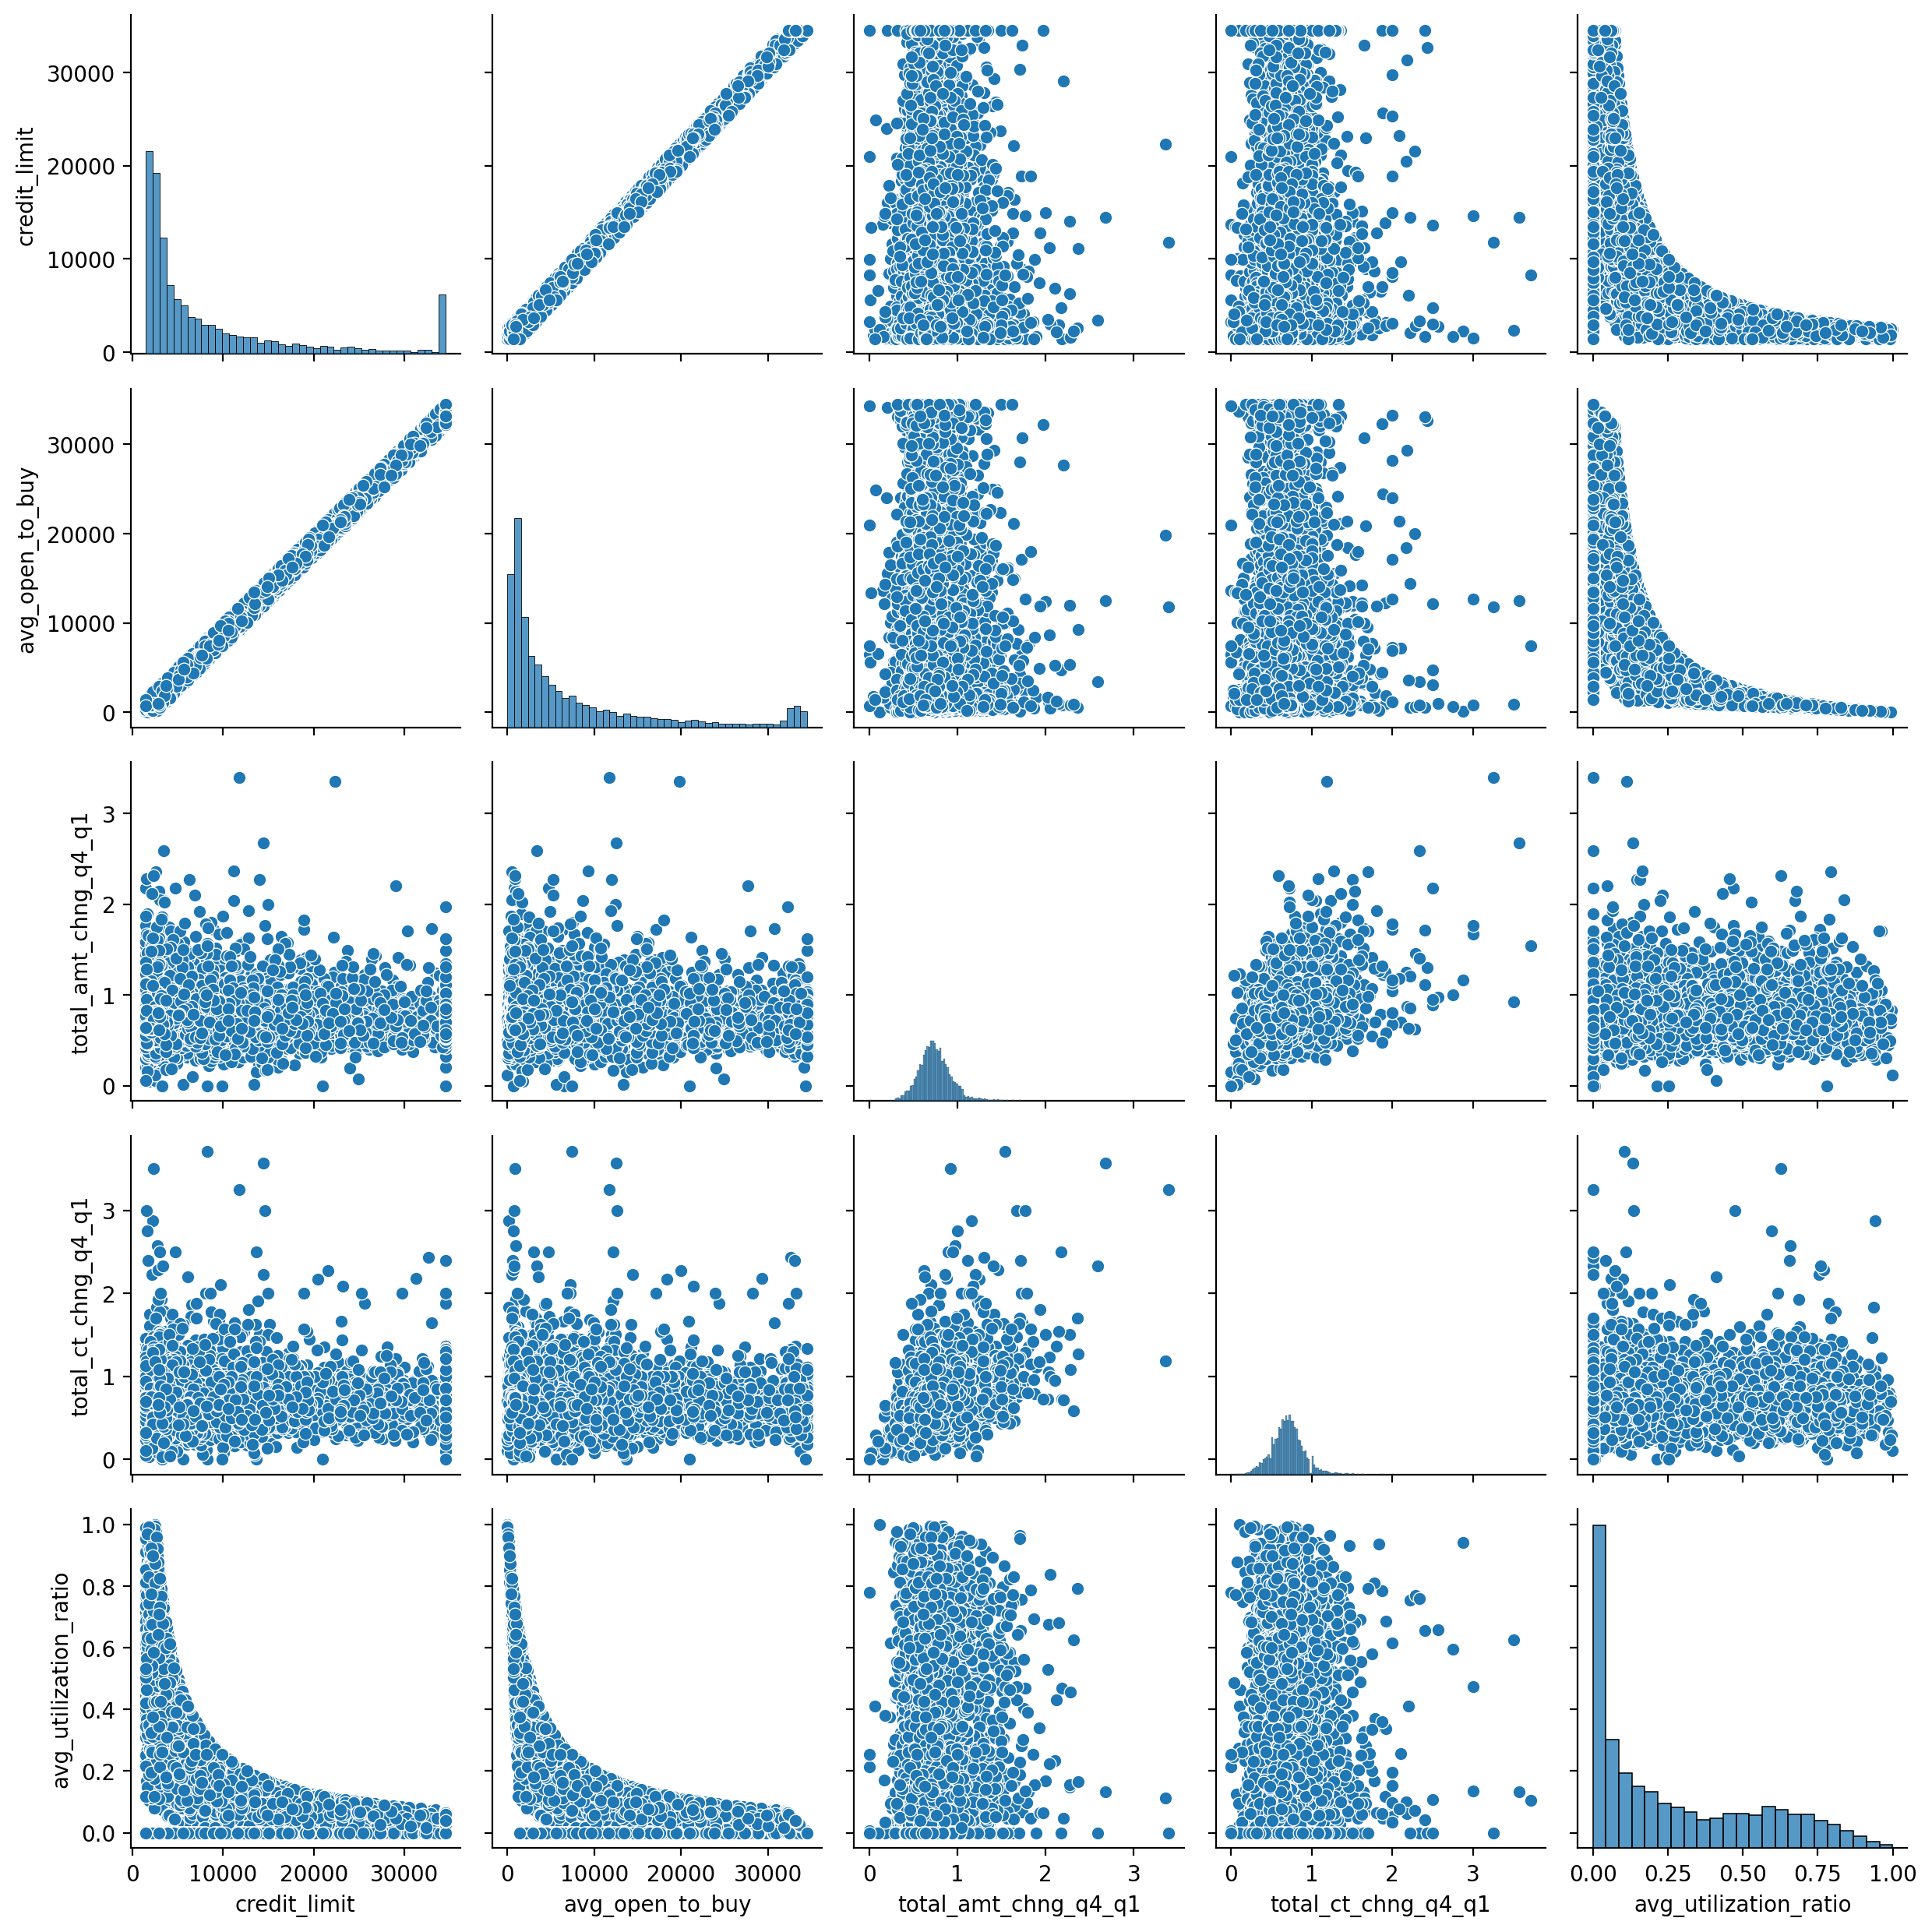

In [29]:
sns.pairplot(df_churn.select_dtypes('float'));
plt.tight_layout();


### Explore differences in customer patterns with respect to churn outcome

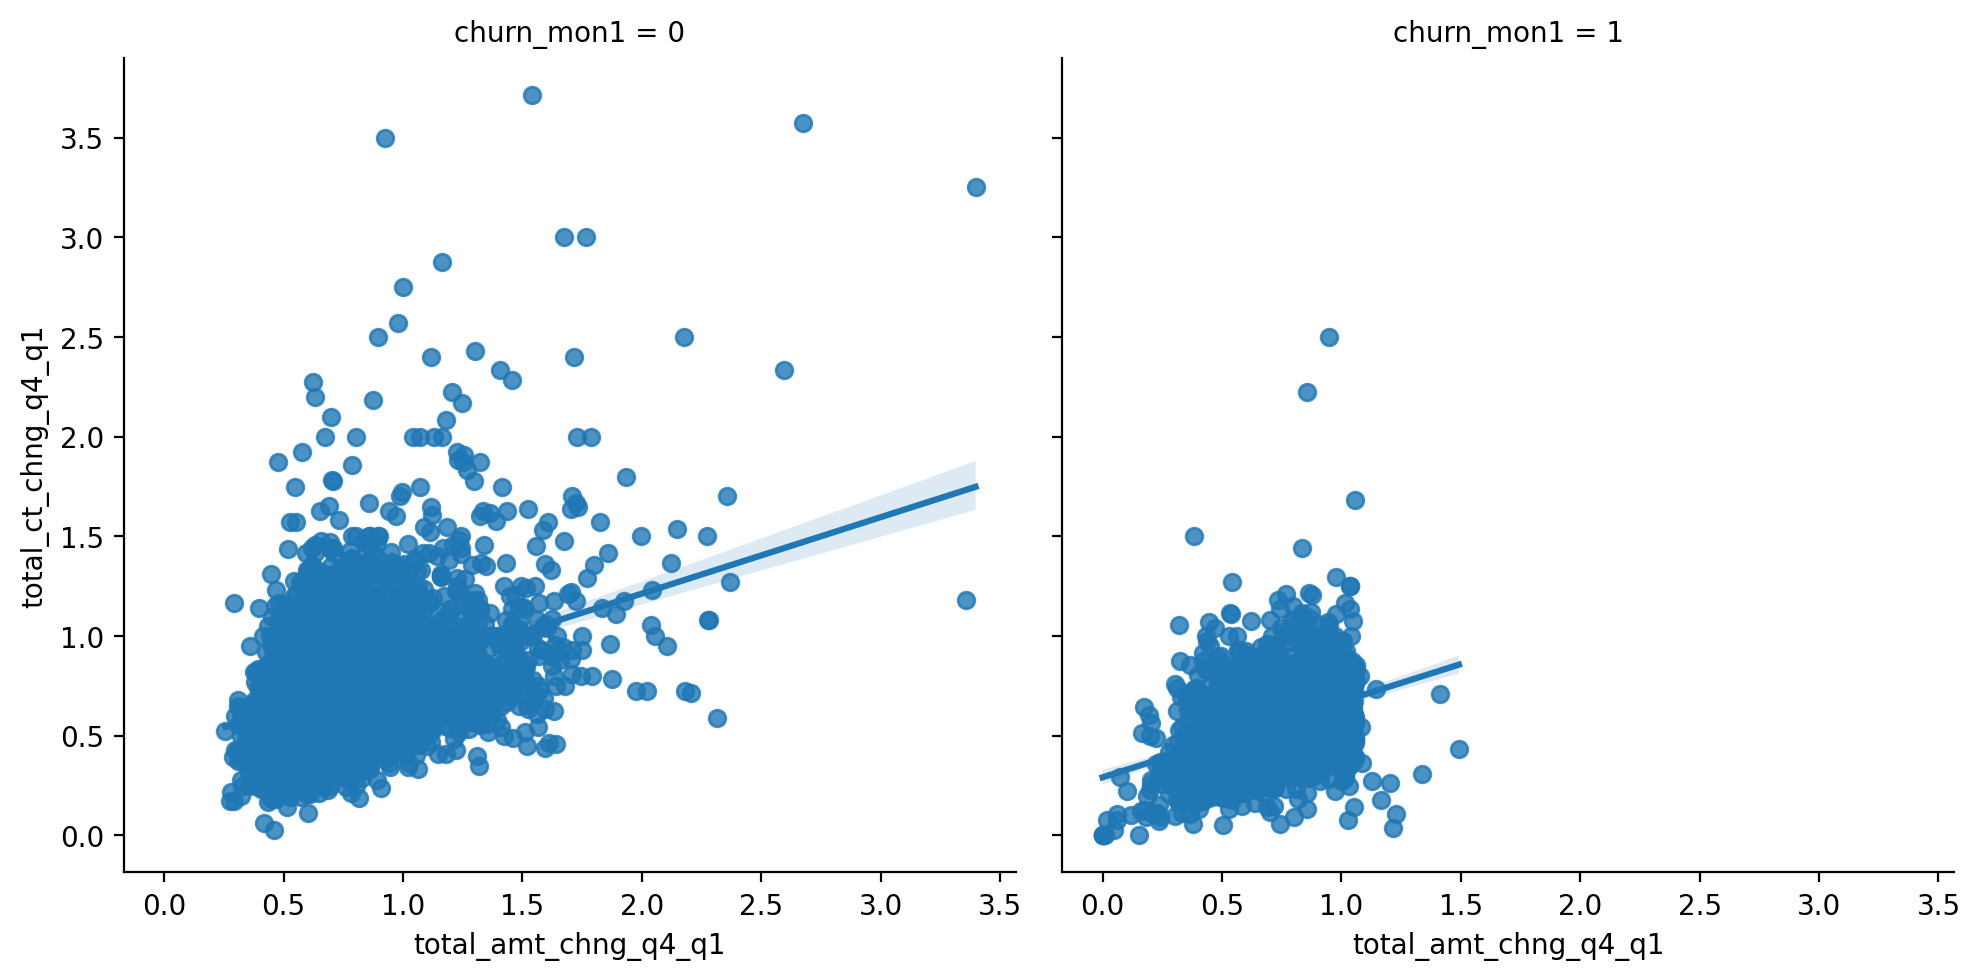

In [32]:
sns.lmplot(x="total_amt_chng_q4_q1", y="total_ct_chng_q4_q1", col="churn_mon1", data=df_churn);
plt.tight_layout();


### Retrieve number of churners

In [33]:
statement_table = '''
SELECT churn_mon1, COUNT(churn_mon1) as nb_churners
FROM {}
GROUP BY churn_mon1
'''.format(athena_table_name)


print(statement_table)


SELECT churn_mon1, COUNT(churn_mon1) as nb_churners
FROM bank_churn_month1
GROUP BY churn_mon1



In [34]:
df_count_churners = wr.athena.read_sql_query(
        sql=statement_table,
        database=database_name
)


df_count_churners

,churn_mon1,nb_churners
0,1,1627
1,0,8500


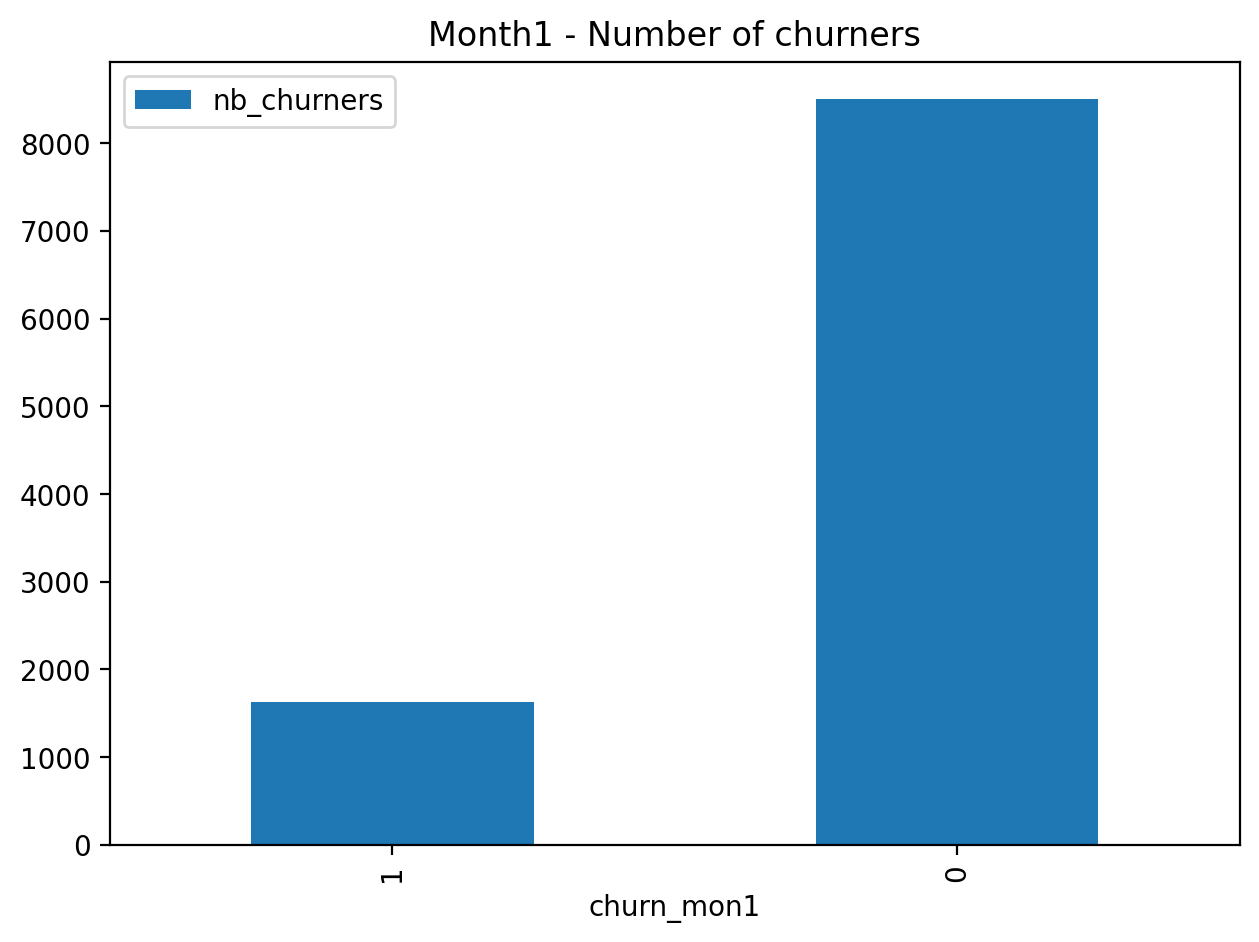

In [35]:
df_count_churners.plot(x='churn_mon1', kind='bar', title='Month1 - Number of churners')
plt.tight_layout();


### Retrieve number of churners according to education level

In [36]:
statement_table = '''
SELECT education_level, churn_mon1, COUNT(churn_mon1) as nb_churners
FROM {}
GROUP BY education_level, churn_mon1
ORDER BY education_level
'''.format(athena_table_name)


print(statement_table)


SELECT education_level, churn_mon1, COUNT(churn_mon1) as nb_churners
FROM bank_churn_month1
GROUP BY education_level, churn_mon1
ORDER BY education_level



In [37]:
df_count_churners = wr.athena.read_sql_query(
        sql=statement_table,
        database=database_name
)


df_count_churners

,education_level,churn_mon1,nb_churners
0,College,1,154
1,College,0,859
2,Doctorate,0,356
3,Doctorate,1,95
4,Graduate,1,487
5,Graduate,0,2641
6,High School,0,1707
7,High School,1,306
8,Post-Graduate,0,424
9,Post-Graduate,1,92


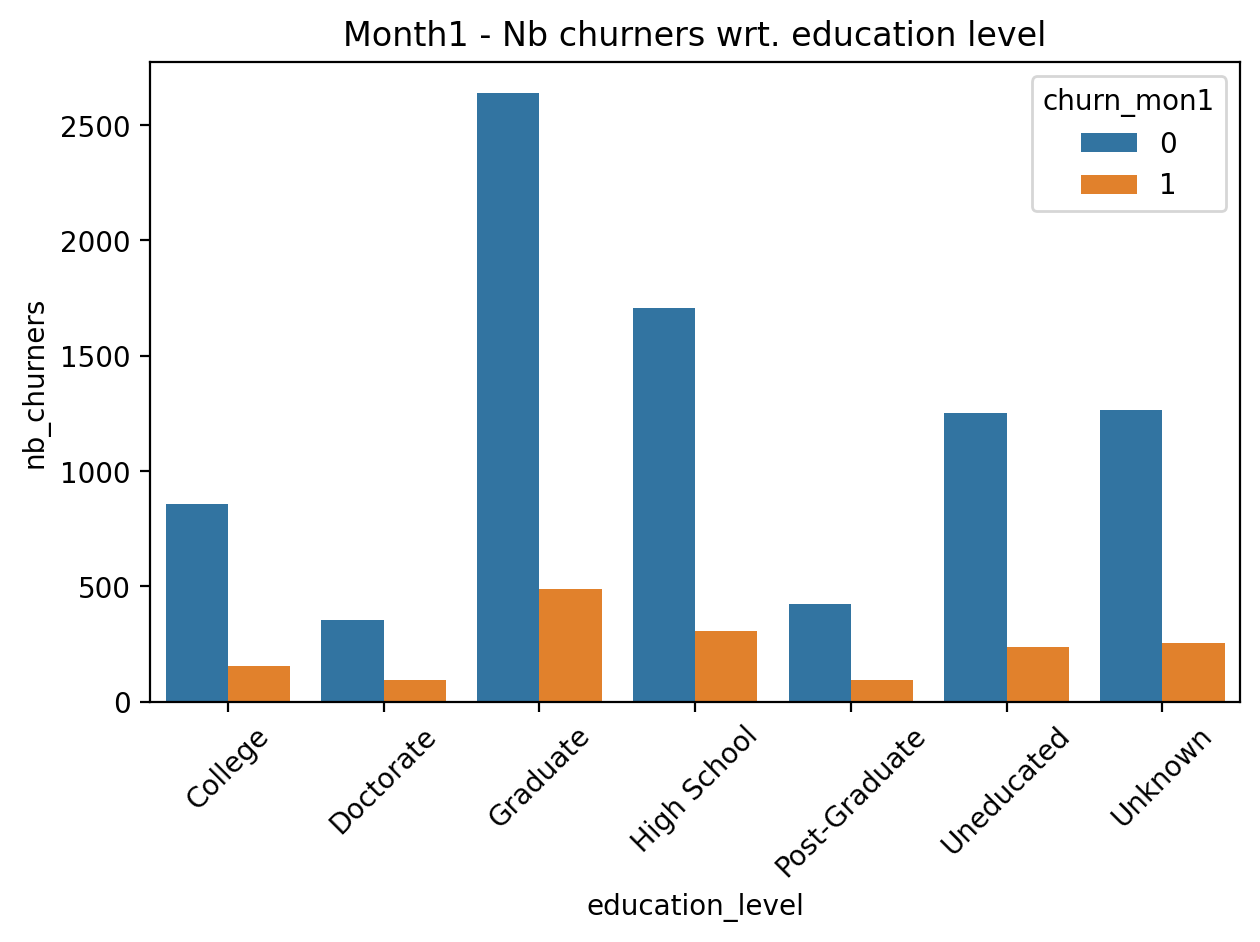

In [38]:
sns.barplot(data=df_count_churners, x ='education_level', y='nb_churners', hue='churn_mon1')
plt.title('Month1 - Nb churners wrt. education level')
plt.xticks(rotation=45)
plt.tight_layout();


### Retrieve number of churners according to customer status

In [39]:
statement_table = '''
SELECT Attrition_Flag, churn_mon1, COUNT(churn_mon1) as nb_churners
FROM {}
GROUP BY Attrition_Flag, churn_mon1
ORDER BY Attrition_Flag
'''.format(athena_table_name)


print(statement_table)


SELECT Attrition_Flag, churn_mon1, COUNT(churn_mon1) as nb_churners
FROM bank_churn_month1
GROUP BY Attrition_Flag, churn_mon1
ORDER BY Attrition_Flag



In [40]:
df_count_churners = wr.athena.read_sql_query(
        sql=statement_table,
        database=database_name
)


df_count_churners

,attrition_flag,churn_mon1,nb_churners
0,Attrited Customer,1,1627
1,Existing Customer,0,8500


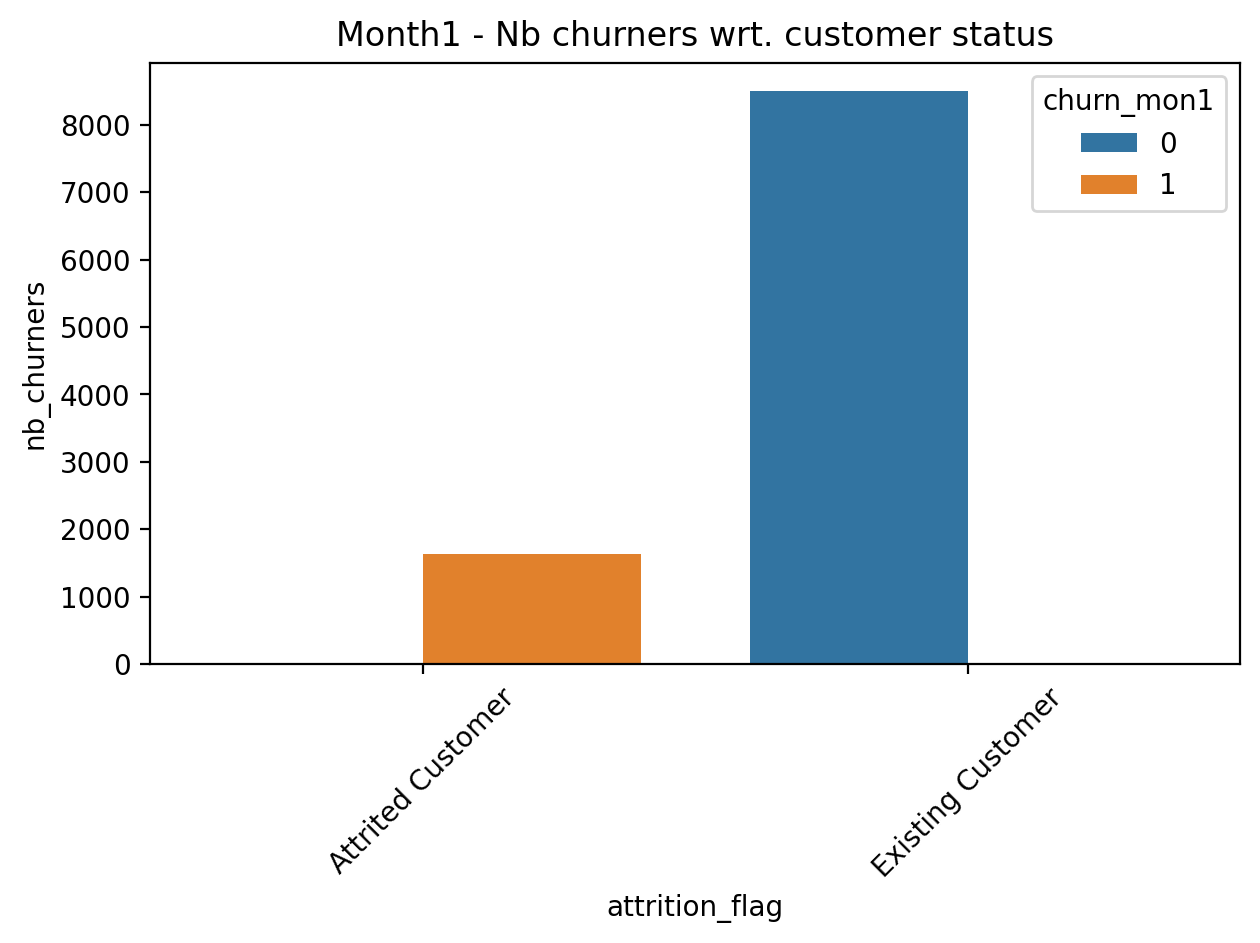

In [41]:
sns.barplot(data=df_count_churners, x ='attrition_flag', y='nb_churners', hue='churn_mon1')
plt.title('Month1 - Nb churners wrt. customer status')
plt.xticks(rotation=45)
plt.tight_layout();


Next Steps:
- Reorganize sections
- Provide descriptions
- Github Repo update